# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import rsnapsim as rss
from skimage.exposure import rescale_intensity
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')

#trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
#gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','Bactin_withTags.txt')

In [3]:
# Paths to dropbox
from sys import platform as _platform
if _platform == "linux" or _platform == "linux2":
    dropbox_address = pathlib.Path('/','home','luisub','Dropbox', 'Project_rSNAPed','manuscript','Figures')
elif _platform == "darwin":
    dropbox_address = pathlib.Path('/','Users','luisaguilera','Dropbox', 'Project_rSNAPed','manuscript','Figures')

In [4]:
# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [5]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1 # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 50    # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 60     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.5    # PLEASE TEST MIN 0.1 MAX 2

In [6]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'

In [7]:
particle_size = 7 # spot size for the simulation and tracking.
elongation_rate = 10
initiation_rate = 0.03

In [8]:
intensity_scale_ch0 = 200
intensity_scale_ch1 = 200
intensity_scale_ch2 = 200

In [9]:
particle_detection_size = particle_size

In [10]:
def rsnapsim_ssa(gene_file,ke,ki,frames=300,frame_rate=1,n_traj=20):
    '''
    This function uses rsnapsim to simulate the single-molecule translation dynamics of any gene.
    Inputs:
    gene_file : str, with the location of a fasta file.
    ke : float, elongation rate.
    ki: float, initiation rate.
    frames: int, total number of simulation frames in seconds.
    n_traj: int, number of trajectories to simulate
    frame_rate : int, frame rate per second
    Outputs:
    ssa_int : NumPy array with dimenssions [Time_points, simulated_trajectories]
    '''
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(str(gene_file))
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke_mu = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 1000
    t = np.linspace(0,t_burnin+frames,(t_burnin+frames+1)*(frame_rate))
    number_probes = np.amax(gene_obj.probe_vec)
    ints = []
    #for i in tq.tqdm(range(n_traj)):
    counter = 0
    while counter < n_traj:
      ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=True,record_stats=False,n_traj=1)
      ssa_int =  ssa_solution.intensity_vec[0,t_burnin*frame_rate:-1,:]
      if np.mean(ssa_int)> 1:
        ints.append(ssa_int)
        counter +=1
    ssa = np.array(ints).reshape(n_traj,frames) #flatten the lists back to a numpy array

    ssa_ump = ssa/number_probes
    return ssa, ssa_ump, gene_obj, t,number_probes

## Running the simulations

In [11]:
def fun_simulated_cells(current_dir, video_dir,ke=3,ki=0.03,gene_file =None, trajectories_dir=None, number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video):
    spot_size = particle_size
    spot_sigma = 1
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        output_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        
        selected_cell = 1
        if not(selected_cell is None):
            video_path = path_files[counter]     
        else:
            video_path = path_files[selected_cell]   
        video = imread(video_path) 

        # Reducing in a half the intensity in the original video
        #video = video//2
        
        counter +=1
        if counter>=len(path_files):
            counter =0
        if not (trajectories_dir is None ):
            # Loading trajectories from file
            ssa_trajectories = np.load(str(trajectories_dir))
            random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
            simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        else:
            # Simulations for intensity
            ssa1,ssa1_ump,_,_,number_probes = rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch1 = ssa1_ump
            ssa2,ssa1_ump,_,_,number_probes =  rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch2 = ssa1_ump
        simulated_trajectories_ch0 = None
        simulated_trajectories_ch0 = simulated_trajectories_ch2
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , spot_positions_movement, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=simulated_trajectories_ch0, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=0,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=1,frame_selection_empty_video=frame_selection_empty_video ,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path

In [12]:
# running the simulation
start = timer()
output_directory_name = fun_simulated_cells(current_dir,video_dir,ke=elongation_rate, ki=initiation_rate,trajectories_dir=None,gene_file= gene_file, number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')

Time to generate simulated data: 21  sec


In [13]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos_original = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [14]:
# Rescaling images
rescale_video = False
if rescale_video == True:
    list_videos = []
    number_channels = list_videos_original[0].shape[-1]
    number_z_slices = list_videos_original[0].shape[0]
    for i in range (0,nimg ):
        temp_img = np.zeros_like(list_videos_original[0])
        for j in range(0,number_channels):
            temp_img[:,:,:,j] =  np.asarray( [ rescale_intensity(list_videos_original[i][z,:,:,j], in_range='image', out_range='dtype')  for z in range (0, number_z_slices)]  )
        list_videos.append(temp_img)
else:
    list_videos = list_videos_original

In [15]:
# Reads the dataframes
list_files_dfnames = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.csv') in f], key=str.lower)  # reading all tif files in the folder
list_files_dfnames.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files_df = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_dfnames ] # creating the complete path for each file
list_df_real_positions = [pd.read_csv(f) for f in  path_files_df] # List with all the videos

## Display results as images

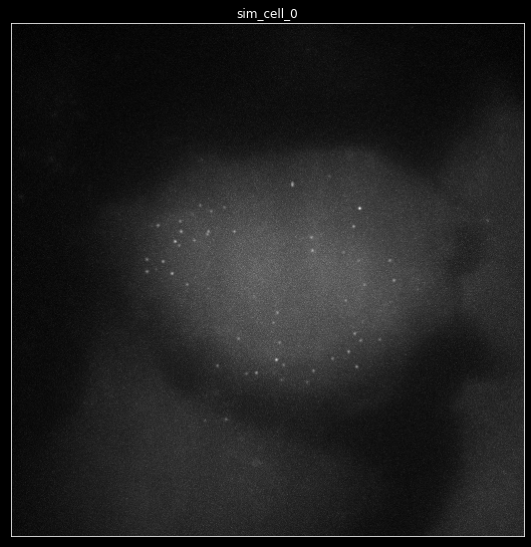

In [16]:
# Showing the simulated images
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_timepoint= 0,normalize=0,individual_figure_size=10).plot()

  0%|          | 0/1 [00:00<?, ?it/s]

mask time: 4  sec


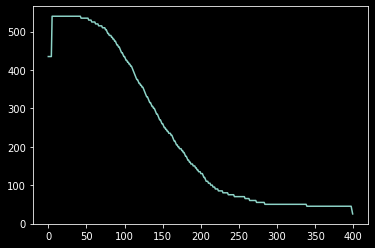

tracking time: 11  sec
intensity calculation time: 2  sec


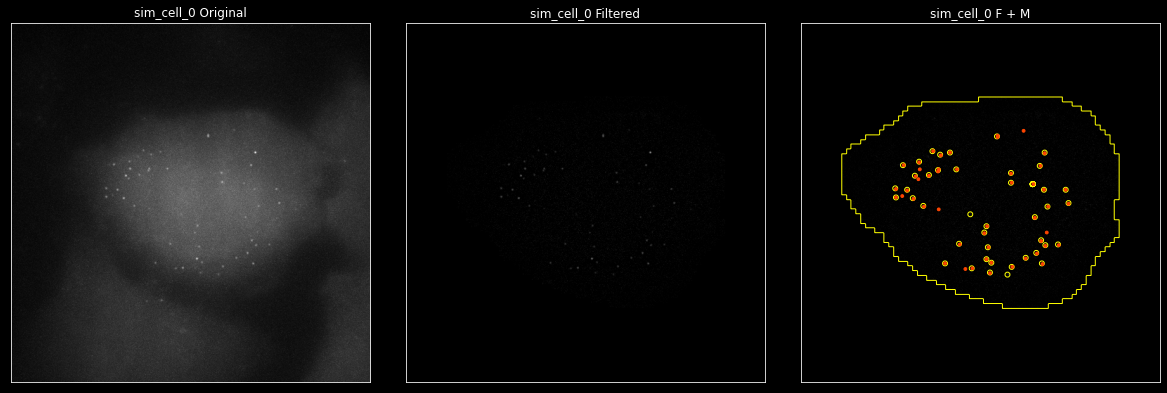

In [17]:
#intensity_selection_method =intensity_selection_method, mask_selection_method = mask_selection_method
list_DataFrame_particles_intensities= []
#list_array_intensities = []
#list_time_vector = []
for i in tqdm(range(0,nimg)): 
    DataFrame_particles_intensities, _, _, _,_, _, _ = rsp.PipelineTracking(list_videos[i],particle_size=particle_detection_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = list_df_real_positions[i],average_cell_diameter=200,print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)
    #list_array_intensities.append(array_intensities)
    #list_time_vector.append(time_vector)

In [18]:
list_DataFrame_particles_intensities
df =list_DataFrame_particles_intensities[0]
df

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue
0,0,0,0,121.000000,398.336731,296.316315,179.682373,529.838418,442.034797,351.818047,261.088747,1.019181,0.658250,0.453967,1872.324951,7751.658203,7751.483398,121.347511,498.561920,498.566956
1,0,0,1,122.438774,327.173462,225.581635,171.915904,555.502545,468.216147,351.836620,259.979118,1.051154,0.553862,0.354261,1874.133301,7809.616699,7809.266602,117.780518,507.449310,507.578003
2,0,0,2,105.969391,350.897949,249.306122,189.674060,501.400416,427.745929,351.854385,258.848091,0.856111,0.591597,0.391348,1881.050049,7835.558105,7835.208496,121.969322,505.985748,506.193420
3,0,0,3,105.969391,350.897949,249.306122,189.674060,501.400416,427.745929,351.854385,258.848091,0.856111,0.591597,0.391348,1881.050049,7835.558105,7835.208496,121.969322,505.985748,506.193420
4,0,0,4,99.367348,226.295914,124.704079,198.286094,522.725002,445.957442,352.896321,257.914925,0.770670,0.346025,0.143719,1872.216675,7847.616699,7847.266602,123.464844,500.481415,500.541992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,0,54,55,39.693878,142.091843,142.091843,116.985121,373.725367,373.725367,182.064920,255.369216,0.258415,0.263607,0.295024,1677.291626,4644.191895,4632.524902,98.300339,377.075592,376.467896
2602,0,54,56,41.693878,151.591843,151.591843,116.985121,373.725367,373.725367,182.062838,255.396171,0.314511,0.301385,0.305854,1671.991699,4629.500000,4627.225098,97.618690,378.558411,380.465515
2603,0,54,57,41.693878,151.591843,151.591843,116.985121,373.725367,373.725367,182.062838,255.396171,0.314511,0.301385,0.305854,1671.991699,4629.500000,4627.225098,97.618690,378.558411,380.465515
2604,0,54,58,40.193878,151.591843,151.591843,116.985121,373.725367,373.725367,182.062838,255.396171,0.308703,0.296661,0.304264,1672.516724,4631.049805,4627.750000,97.754623,379.362671,380.728210


In [19]:
all_data = True
sel_timepoint = 0

In [20]:
print(list_videos[0][0,:,:,0].mean())
print(list_videos[0][0,:,:,1].mean())
print(list_videos[0][0,:,:,2].mean())

1084.9104042053223
2453.1260871887207
2453.092502593994


# Plotting figures

In [21]:
fig_size = (14, 2.5)
f = plt.figure(figsize=fig_size)
def fun_scatter_plot(x,y, title='', xlab='', ylab='',
                alpha=1, color='r',
                subplots=False, show_grid=True, fig=f,font_size=8):
    m, b = np.polyfit(x,y, 1)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    #axarr = f.add_subplot(1,1,1)
    plt.scatter(x, y, alpha=alpha, color=color, s= 2)
    plt.plot(x, m*x + b,'-w',linewidth=2)
    plt.plot(mean_x,mean_y,'o',color='w' ,  markersize=10)
    plt.xlim(min(x), max(x))
    plt.xlabel(xlab, size=font_size)
    plt.ylabel(ylab, size=font_size)
    plt.grid(show_grid)
    plt.title(title, size=font_size)
    return(f)

<Figure size 1008x180 with 0 Axes>

## Channels

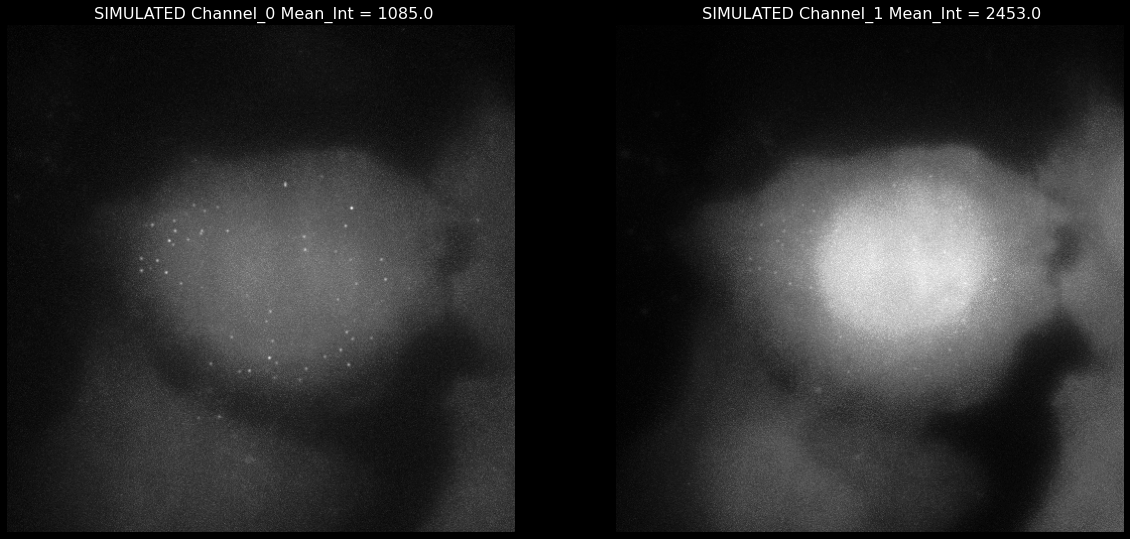

In [22]:
selected_timePoint = 0 # selecting a frame to display in the plot.
fig_size = (20, 10)
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=fig_size)
for i in range(0,2):
  mean_int = list_videos[0][selected_timePoint,:,:,i].mean()
  ax[i].imshow(list_videos[0][selected_timePoint,:,:,i],cmap='Greys_r')
  ax[i].axis('off')
  ax[i].set_title(' SIMULATED Channel_'+str(i) + ' Mean_Int = ' +str(round(mean_int,0)) , size=16)
plt.savefig('./results/sim_cell.png')
plt.show()


## Intensity distribution

In [23]:
plt.style.use('ggplot')

In [24]:
fig_size = (14, 2.5)
font_size = 8 


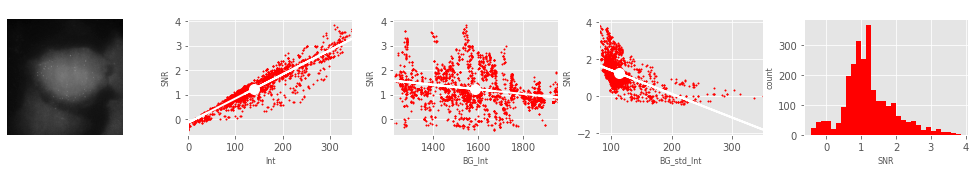

In [25]:
f = plt.figure(figsize=fig_size)
channel = 0
f.add_subplot(1,5,1) 
mean_int = list_videos[0][selected_timePoint,:,:,channel].mean()
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
#plt.title(' SIMULATED CH_'+str(channel) + ' mu_Int = ' +str(round(mean_int,0)) , size=16)

f.add_subplot(1,5,2) 
fun_scatter_plot(x = df.red_int_mean.values, y= df.SNR_red.values, title='Int vs SNR', xlab='Int', ylab='SNR', fig=f, color='r',font_size=font_size)
f.add_subplot(1,5,3) 
fun_scatter_plot(x = df.background_int_mean_red.values, y= df.SNR_red.values, title='BG_Int vs SNR', xlab='BG_Int', ylab='SNR', fig=f, color='r',font_size=font_size)
f.add_subplot(1,5,4) 
fun_scatter_plot(x = df.background_int_std_red.values, y= df.SNR_red.values, title='BG_std_Int vs SNR', xlab='BG_std_Int', ylab='SNR', fig=f, color='r',font_size=font_size)

# adding the histogram
f.add_subplot(1,5,5) # here is where you add the subplot to f
f=plt.hist(df.SNR_red.values,bins=30,color='r')
#plt.title('dist SNR', size=16)
plt.ylabel('count', size=font_size)
plt.xlabel('SNR', size=font_size)

plt.tight_layout() 
plt.subplots_adjust(wspace=0.25, hspace=0)

name_figure = 'simulated_SNR_ch0.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")


plt.show()


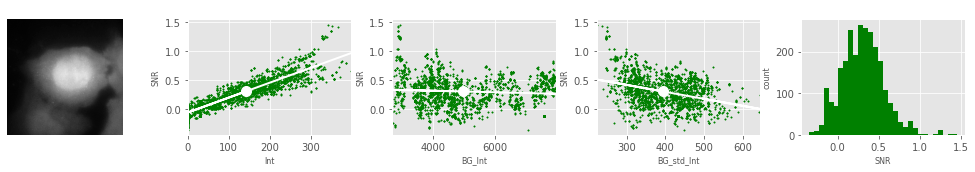

In [26]:
f = plt.figure(figsize=fig_size)

channel = 1
f.add_subplot(1,5,1) 
mean_int = list_videos[0][selected_timePoint,:,:,channel].mean()
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
#plt.title(' REAL CH_'+str(channel) + ' mu_Int = ' +str(round(mean_int,0)) , size=16)

f.add_subplot(1,5,2) 
fun_scatter_plot(x = df.green_int_mean.values, y= df.SNR_green.values, title='Int vs SNR', xlab='Int', ylab='SNR', fig=f, color='g',font_size=font_size)
f.add_subplot(1,5,3) 
fun_scatter_plot(x = df.background_int_mean_green.values, y= df.SNR_green.values, title='BG_Int vs SNR', xlab='BG_Int', ylab='SNR', fig=f, color='g',font_size=font_size)
f.add_subplot(1,5,4) 
fun_scatter_plot(x = df.background_int_std_green.values, y= df.SNR_green.values, title='BG_std_Int vs SNR', xlab='BG_std_Int', ylab='SNR', fig=f, color='g',font_size=font_size)

# adding the histogram
f.add_subplot(1,5,5) # here is where you add the subplot to f
f=plt.hist(df.SNR_green.values,bins=30,color='g')
#plt.title('dist SNR', size=16)
plt.ylabel('count', size=font_size)
plt.xlabel('SNR', size=font_size)

plt.tight_layout() 
plt.subplots_adjust(wspace=0.25, hspace=0)

name_figure = 'simulated_SNR_ch1.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")

plt.show()
